In [2]:
import numpy as np
import pandas as pd


## importing functions 

In [4]:
def get_ind_file(filetype, weighting="vw", n_inds=30):
    """
    Load and format the Ken French Industry Portfolios files
    Variant is a tuple of (weighting, size) where:
        weighting is one of "ew", "vw"
        number of inds is 30 or 49
    """    
    if filetype == "returns":
        name = f"{weighting}_rets" 
        divisor = 100
    elif filetype == "nfirms":
        name = "nfirms"
        divisor = 1
    elif filetype == "size":
        name = "size"
        divisor = 1
    else:
        raise ValueError(f"filetype must be one of: returns, nfirms, size")
    
    ind = pd.read_csv(f"data/ind{n_inds}_m_{name}.csv", header=0, index_col=0, na_values=-99.99)/divisor
    ind.index = pd.to_datetime(ind.index, format="%Y%m").to_period('M')
    ind.columns = ind.columns.str.strip()
    return ind


def get_ind_returns(weighting="vw", n_inds=30):
    """
    Load and format the Ken French Industry Portfolios Monthly Returns
    """
    return get_ind_file("returns", weighting=weighting, n_inds=n_inds)

def get_ind_nfirms(n_inds=30):
    """
    Load and format the Ken French 30 Industry Portfolios Average number of Firms
    """
    return get_ind_file("nfirms", n_inds=n_inds)

def get_ind_size(n_inds=30):
    """
    Load and format the Ken French 30 Industry Portfolios Average size (market cap)
    """
    return get_ind_file("size", n_inds=n_inds)


def get_ind_market_caps(n_inds=30, weights=False):
    """
    Load the industry portfolio data and derive the market caps
    """
    ind_nfirms = get_ind_nfirms(n_inds=n_inds)
    ind_size = get_ind_size(n_inds=n_inds)
    ind_mktcap = ind_nfirms * ind_size
    if weights:
        total_mktcap = ind_mktcap.sum(axis=1)
        ind_capweight = ind_mktcap.divide(total_mktcap, axis="rows")
        return ind_capweight
    #else
    return ind_mktcap

def get_total_market_index_returns(n_inds=30):
    """
    Load the 30 industry portfolio data and derive the returns of a capweighted total market index
    """
    ind_capweight = get_ind_market_caps(n_inds=n_inds)
    ind_return = get_ind_returns(weighting="vw", n_inds=n_inds)
    total_market_return = (ind_capweight * ind_return).sum(axis="columns")
    return total_market_return

## helper functions 

In [7]:
def weight_cw(r, cap_weights, **kwargs):
    """
    Returns the weights of the CW portfolio based on the time series of capweights
    """
    w = cap_weights.loc[r.index[0]]
    return w/w.sum()

def weight_ew(r, cap_weights=None, max_cw_mult=None, microcap_threshold=None, **kwargs):
    """
    Returns the weights of the EW portfolio based on the asset returns "r" as a DataFrame
    If supplied a set of capweights and a capweight tether, it is applied and reweighted 
    """
    n = len(r.columns)
    ew = pd.Series(1/n, index=r.columns)
    if cap_weights is not None:
        cw = cap_weights.loc[r.index[0]] # starting cap weight
        ## exclude microcaps
        if microcap_threshold is not None and microcap_threshold > 0:
            microcap = cw < microcap_threshold
            ew[microcap] = 0
            ew = ew/ew.sum()
        #limit weight to a multiple of capweight
        if max_cw_mult is not None and max_cw_mult > 0:
            ew = np.minimum(ew, cw*max_cw_mult)
            ew = ew/ew.sum() #reweight
    return ew

def weight_cw(r, cap_weights, **kwargs):
    """
    Returns the weights of the CW portfolio based on the time series of capweights
    """
    w = cap_weights.loc[r.index[0]]
    return w/w.sum()


def backtest_ws(r, estimation_window=60, weighting=weight_ew, verbose=False, **kwargs):
    """
    Backtests a given weighting scheme, given some parameters:
    r : asset returns to use to build the portfolio
    estimation_window: the window to use to estimate parameters
    weighting: the weighting scheme to use, must be a function that takes "r", and a variable number of keyword-value arguments
    """
    n_periods = r.shape[0]
    # return windows
    windows = [(start, start+estimation_window) for start in range(n_periods-estimation_window)]
    weights = [weighting(r.iloc[win[0]:win[1]], **kwargs) for win in windows]
    # convert List of weights to DataFrame
    weights = pd.DataFrame(weights, index=r.iloc[estimation_window:].index, columns=r.columns)
    returns = (weights * r).sum(axis="columns",  min_count=1) #mincount is to generate NAs if all inputs are NAs
    return returns

## summary functions

In [8]:
import scipy.stats
from scipy.stats import norm
def skewness(r):
    """
    Alternative to scipy.stats.skew()
    Computes the skewness of the supplied Series or DataFrame
    Returns a float or a Series
    """
    demeaned_r = r - r.mean()
    # use the population standard deviation, so set dof=0
    sigma_r = r.std(ddof=0)
    exp = (demeaned_r**3).mean()
    return exp/sigma_r**3


def kurtosis(r):
    """
    Alternative to scipy.stats.kurtosis()
    Computes the kurtosis of the supplied Series or DataFrame
    Returns a float or a Series
    """
    demeaned_r = r - r.mean()
    # use the population standard deviation, so set dof=0
    sigma_r = r.std(ddof=0)
    exp = (demeaned_r**4).mean()
    return exp/sigma_r**4

def drawdown(return_series: pd.Series):
    """Takes a time series of asset returns.
       returns a DataFrame with columns for
       the wealth index, 
       the previous peaks, and 
       the percentage drawdown
    """
    wealth_index = 1000*(1+return_series).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks
    return pd.DataFrame({"Wealth": wealth_index, 
                         "Previous Peak": previous_peaks, 
                         "Drawdown": drawdowns})



def compound(r):
    """
    returns the result of compounding the set of returns in r
    """
    return np.expm1(np.log1p(r).sum())

                         
def annualize_rets(r, periods_per_year):
    """
    Annualizes a set of returns
    We should infer the periods per year
    but that is currently left as an exercise
    to the reader :-)
    """
    compounded_growth = (1+r).prod()
    n_periods = r.shape[0]
    return compounded_growth**(periods_per_year/n_periods)-1


def annualize_vol(r, periods_per_year):
    """
    Annualizes the vol of a set of returns
    We should infer the periods per year
    but that is currently left as an exercise
    to the reader :-)
    """
    return r.std()*(periods_per_year**0.5)


def sharpe_ratio(r, riskfree_rate, periods_per_year):
    """
    Computes the annualized sharpe ratio of a set of returns
    """
    # convert the annual riskfree rate to per period
    rf_per_period = (1+riskfree_rate)**(1/periods_per_year)-1
    excess_ret = r - rf_per_period
    ann_ex_ret = annualize_rets(excess_ret, periods_per_year)
    ann_vol = annualize_vol(r, periods_per_year)
    return ann_ex_ret/ann_vol



def is_normal(r, level=0.01):
    """
    Applies the Jarque-Bera test to determine if a Series is normal or not
    Test is applied at the 1% level by default
    Returns True if the hypothesis of normality is accepted, False otherwise
    """
    if isinstance(r, pd.DataFrame):
        return r.aggregate(is_normal)
    else:
        statistic, p_value = scipy.stats.jarque_bera(r)
        return p_value > level


def semideviation(r):
    """
    Returns the semideviation aka negative semideviation of r
    r must be a Series or a DataFrame, else raises a TypeError
    """
    if isinstance(r, pd.Series):
        is_negative = r < 0
        return r[is_negative].std(ddof=0)
    elif isinstance(r, pd.DataFrame):
        return r.aggregate(semideviation)
    else:
        raise TypeError("Expected r to be a Series or DataFrame")


def var_historic(r, level=5):
    """
    Returns the historic Value at Risk at a specified level
    i.e. returns the number such that "level" percent of the returns
    fall below that number, and the (100-level) percent are above
    """
    if isinstance(r, pd.DataFrame):
        return r.aggregate(var_historic, level=level)
    elif isinstance(r, pd.Series):
        return -np.percentile(r, level)
    else:
        raise TypeError("Expected r to be a Series or DataFrame")


def cvar_historic(r, level=5):
    """
    Computes the Conditional VaR of Series or DataFrame
    """
    if isinstance(r, pd.Series):
        is_beyond = r <= -var_historic(r, level=level)
        return -r[is_beyond].mean()
    elif isinstance(r, pd.DataFrame):
        return r.aggregate(cvar_historic, level=level)
    else:
        raise TypeError("Expected r to be a Series or DataFrame")



def var_gaussian(r, level=5, modified=False):
    """
    Returns the Parametric Gauusian VaR of a Series or DataFrame
    If "modified" is True, then the modified VaR is returned,
    using the Cornish-Fisher modification
    """
    # compute the Z score assuming it was Gaussian
    z = norm.ppf(level/100)
    if modified:
        # modify the Z score based on observed skewness and kurtosis
        s = skewness(r)
        k = kurtosis(r)
        z = (z +
                (z**2 - 1)*s/6 +
                (z**3 -3*z)*(k-3)/24 -
                (2*z**3 - 5*z)*(s**2)/36
            )
    return -(r.mean() + z*r.std(ddof=0))
    
def summary_stats(r, riskfree_rate=0.03):
    """
    Return a DataFrame that contains aggregated summary stats for the returns in the columns of r
    """
    ann_r = r.aggregate(annualize_rets, periods_per_year=12)
    ann_vol = r.aggregate(annualize_vol, periods_per_year=12)
    ann_sr = r.aggregate(sharpe_ratio, riskfree_rate=riskfree_rate, periods_per_year=12)
    dd = r.aggregate(lambda r: drawdown(r).Drawdown.min())
    skew = r.aggregate(skewness)
    kurt = r.aggregate(kurtosis)
    cf_var5 = r.aggregate(var_gaussian, modified=True)
    hist_cvar5 = r.aggregate(cvar_historic)
    return pd.DataFrame({
        "Annualized Return": ann_r,
        "Annualized Vol": ann_vol,
        "Skewness": skew,
        "Kurtosis": kurt,
        "Cornish-Fisher VaR (5%)": cf_var5,
        "Historic CVaR (5%)": hist_cvar5,
        "Sharpe Ratio": ann_sr,
        "Max Drawdown": dd
    })

## GmV functions 

In [12]:
def msr(riskfree_rate, er, cov):
    """
    Returns the weights of the portfolio that gives you the maximum sharpe ratio
    given the riskfree rate and expected returns and a covariance matrix
    """
    n = er.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n # an N-tuple of 2-tuples!
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    def neg_sharpe(weights, riskfree_rate, er, cov):
        """
        Returns the negative of the sharpe ratio
        of the given portfolio
        """
        r = portfolio_return(weights, er)
        vol = portfolio_vol(weights, cov)
        return -(r - riskfree_rate)/vol
    
    weights = minimize(neg_sharpe, init_guess,
                       args=(riskfree_rate, er, cov), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,),
                       bounds=bounds)
    return weights.x

def gmv(cov):
    """
    Returns the weights of the Global Minimum Volatility portfolio
    given a covariance matrix
    """
    n = cov.shape[0]
    return msr(0, np.repeat(1, n), cov)

def sample_cov(r, **kwargs):
    """
    Returns the sample covariance of the supplied returns
    """
    return r.cov()

def weight_gmv(r, cov_estimator=sample_cov, **kwargs):
    """
    Produces the weights of the GMV portfolio given a covariance matrix of the returns 
    """
    est_cov = cov_estimator(r, **kwargs)
    return gmv(est_cov)

def portfolio_return(weights, returns):
    """
    Computes the return on a portfolio from constituent returns and weights
    weights are a numpy array or Nx1 matrix and returns are a numpy array or Nx1 matrix
    """
    return weights.T @ returns

def portfolio_vol(weights, covmat):
    """
    Computes the vol of a portfolio from a covariance matrix and constituent weights
    weights are a numpy array or N x 1 maxtrix and covmat is an N x N matrix
    """
    vol = (weights.T @ covmat @ weights)**0.5
    return vol 

### Importing Data

In [15]:
inds=['Beer', 'Hlth', 'Fin','Rtail','Whlsl']
ind_rets = get_ind_returns(weighting="vw", n_inds=49)["1974":]
ind_mcap = get_ind_market_caps(49, weights=True)["1974":]

rets = ind_rets["2013":][inds]
cov = rets.cov()

# 1- Risk Contribution for each 

In [19]:
def risk_contribution(w,cov):
    """
    Compute the contributions to risk of the constituents of a portfolio, given a set of portfolio weights and a covariance matrix
    """
    total_portfolio_var = portfolio_vol(w,cov)**2
    # Marginal contribution of each constituent
    marginal_contrib = cov@w
    risk_contrib = np.multiply(marginal_contrib,w.T)/total_portfolio_var
    return risk_contrib

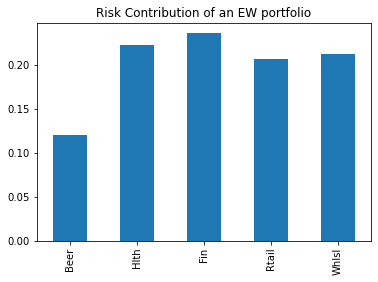

In [22]:
risk_contribution(weight_ew(rets), cov).plot.bar(title='Risk Contribution of an EW portfolio')

#### functions to equaly weight the risk inside the portifolio

In [23]:
from scipy.optimize import minimize

def target_risk_contributions(target_risk, cov):
    """
    Returns the weights of the portfolio that gives you the weights such
    that the contributions to portfolio risk are as close as possible to
    the target_risk, given the covariance matrix
    """
    n = cov.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n # an N-tuple of 2-tuples!
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    def msd_risk(weights, target_risk, cov):
        """
        Returns the Mean Squared Difference in risk contributions
        between weights and target_risk
        """
        w_contribs = risk_contribution(weights, cov)
        return ((w_contribs-target_risk)**2).sum()
    
    weights = minimize(msd_risk, init_guess,
                       args=(target_risk, cov), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,),
                       bounds=bounds)
    return weights.x

def equal_risk_contributions(cov):
    """
    Returns the weights of the portfolio that equalizes the contributions
    of the constituents based on the given covariance matrix
    """
    n = cov.shape[0]
    return target_risk_contributions(target_risk=np.repeat(1/n,n), cov=cov)


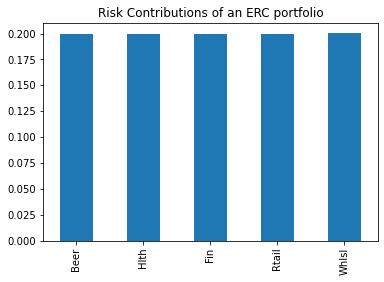

In [24]:
#weights that gives equal risk contributions
risk_contribution(equal_risk_contributions(cov), cov).plot.bar(title="Risk Contributions of an ERC portfolio");

In [26]:
def weight_erc(r, cov_estimator=sample_cov, **kwargs):
    """
    Produces the weights of the ERC portfolio given a covariance matrix of the returns 
    """
    est_cov = cov_estimator(r, **kwargs)
    return equal_risk_contributions(est_cov)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.121052,0.161000,-0.769256,6.572680,0.071993,0.103950,0.550248,-0.528292
CW,0.117007,0.149311,-0.702445,5.458192,0.066685,0.096232,0.566996,-0.518076


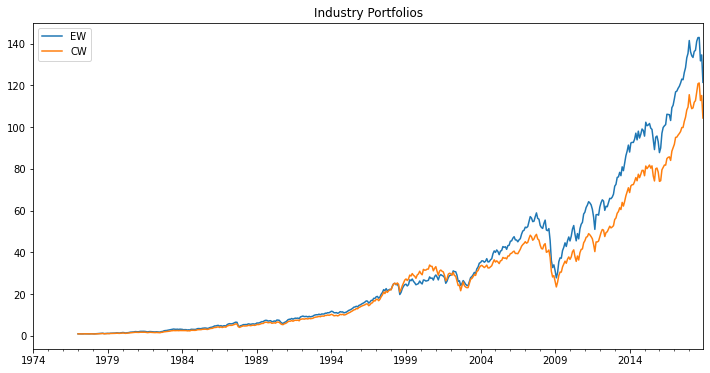

In [31]:
ewr = backtest_ws(ind_rets, estimation_window=36, weighting=weight_ew)
cwr = backtest_ws(ind_rets, estimation_window=36, weighting=weight_cw, cap_weights=ind_mcap)
btr = pd.DataFrame({"EW": ewr, "CW": cwr})
(1+btr).cumprod().plot(figsize=(12,6), title="Industry Portfolios")
summary_stats(btr.dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.121052,0.161000,-0.769256,6.572680,0.071993,0.103950,0.550248,-0.528292
CW,0.117007,0.149311,-0.702445,5.458192,0.066685,0.096232,0.566996,-0.518076
ERC-Sample,0.120185,0.149185,-0.872577,7.019237,0.066886,0.096357,0.588203,-0.502950


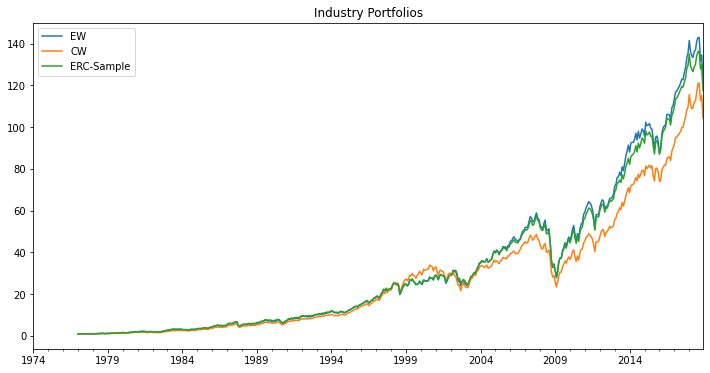

In [33]:
mv_erc_r = backtest_ws(ind_rets, estimation_window=36, weighting=weight_erc, cov_estimator=sample_cov)
btr = pd.DataFrame({"EW": ewr, "CW": cwr, "ERC-Sample": mv_erc_r})
(1+btr).cumprod().plot(figsize=(12,6), title="Industry Portfolios")
summary_stats(btr.dropna())